In [36]:
# Fix imports when running from notebooks/ folder
import sys
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Added to path: {project_root}")

Added to path: /Users/elshaday/DEV/10Academy/sentiment-analysis-week1


In [99]:
%load_ext autoreload
%autoreload 2

import nltk
nltk.downloader.download("vader_lexicon")


from scripts import calculate_sentiment
from src.data import DataManager
from tabulate import tabulate
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/elshaday/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [38]:
print("Load cleaned data:")
dm = DataManager()

try:
    news_df = dm.load_news_data(load_processed=True)
    stock_data = dm.load_all_stocks(load_processed=True)
except Exception as e:
    print(f"Data Loading Failed: {e}")

Load cleaned data:
Loading news data from ../data/processed_data/processed_news.csv
News data loaded successfully.
Loading stock data for AAPL from ../data/processed_data/processed_AAPL.csv
Stock data for AAPL loaded successfully.
Loading stock data for AMZN from ../data/processed_data/processed_AMZN.csv
Stock data for AMZN loaded successfully.
Loading stock data for GOOG from ../data/processed_data/processed_GOOG.csv
Stock data for GOOG loaded successfully.
Loading stock data for META from ../data/processed_data/processed_META.csv
Stock data for META loaded successfully.
Loading stock data for MSFT from ../data/processed_data/processed_MSFT.csv
Stock data for MSFT loaded successfully.
Loading stock data for NVDA from ../data/processed_data/processed_NVDA.csv
Stock data for NVDA loaded successfully.
All stock data loaded successfully.


In [39]:
print("Sentiment Analysis using compund score")

# Remove empty headlines
sentiment_ready_news_df = news_df.dropna(subset=["headline_cleaned"]).copy()

# Calculate sentiment on cleaned headlines with no NA values
sentiment_ready_news_df["sentiment"] = calculate_sentiment(sentiment_ready_news_df["headline_cleaned"])


Sentiment Analysis using compund score


In [93]:
print("Group news records by their published date and take the average sentiment for each day:")

daily_news_sentiment_df = (
    sentiment_ready_news_df
    .groupby(["date_clean"])['sentiment']
    .mean()
    .to_frame()
    .rename(columns={"sentiment": "avg_sentiment"})
)

# Drop time values
daily_news_sentiment_df.index = daily_news_sentiment_df.index.tz_convert(None)

print(tabulate(daily_news_sentiment_df.head(), headers="keys", tablefmt="psql"))

Group news records by their published date and take the average sentiment for each day:
+---------------------+-----------------+
| date_clean          |   avg_sentiment |
|---------------------+-----------------|
| 2009-02-14 00:00:00 |         0.2263  |
| 2009-04-27 00:00:00 |         0       |
| 2009-04-29 00:00:00 |         0       |
| 2009-05-22 00:00:00 |         0       |
| 2009-05-27 00:00:00 |         0.79515 |
+---------------------+-----------------+


In [94]:
print("Select closing price and calculate returns")


daily_stock_data_with_returns = {}

for ticker, df in stock_data.items():
    df = df.copy()
    df["returns"] = df["Close"].pct_change()
    df.fillna({"returns" : 0}, inplace=True)
    df.index = pd.to_datetime(df.index)
    daily_stock_data_with_returns[ticker] = df[["Close", "returns"]]

    print(f"Closing and Returns for {ticker}")
    print(tabulate(daily_news_sentiment_df.head(), headers="keys", tablefmt="psql"))

Select closing price and calculate returns
Closing and Returns for AAPL
+---------------------+-----------------+
| date_clean          |   avg_sentiment |
|---------------------+-----------------|
| 2009-02-14 00:00:00 |         0.2263  |
| 2009-04-27 00:00:00 |         0       |
| 2009-04-29 00:00:00 |         0       |
| 2009-05-22 00:00:00 |         0       |
| 2009-05-27 00:00:00 |         0.79515 |
+---------------------+-----------------+
Closing and Returns for AMZN
+---------------------+-----------------+
| date_clean          |   avg_sentiment |
|---------------------+-----------------|
| 2009-02-14 00:00:00 |         0.2263  |
| 2009-04-27 00:00:00 |         0       |
| 2009-04-29 00:00:00 |         0       |
| 2009-05-22 00:00:00 |         0       |
| 2009-05-27 00:00:00 |         0.79515 |
+---------------------+-----------------+
Closing and Returns for GOOG
+---------------------+-----------------+
| date_clean          |   avg_sentiment |
|---------------------+-------

In [96]:
print("Inner Join daily news sentiment and daily stock data with returns where they have the dame date values")

aligned_stock_data = {
    ticker: df.join(daily_news_sentiment_df, how="inner")
    for ticker, df in daily_stock_data_with_returns.items()
}

# Making sure the right columns are added on the inner join and check if there are any na values that need to be dropped
for ticker, df in aligned_stock_data.items():
    print(f"Checking basic info for {ticker}")
    print(df.isna().sum())
    print(tabulate(df.head(), headers="keys", tablefmt="psql"))

Inner Join daily news sentiment and daily stock data with returns where they have the dame date values
Checking basic info for AAPL
Close            0
returns          0
avg_sentiment    0
dtype: int64
+---------------------+---------+-------------+-----------------+
|                     |   Close |     returns |   avg_sentiment |
|---------------------+---------+-------------+-----------------|
| 2012-05-18 00:00:00 | 15.9066 |  0          |       0.0474858 |
| 2012-05-21 00:00:00 | 16.8334 |  0.0582603  |       0.0590493 |
| 2012-05-22 00:00:00 | 16.7041 | -0.00767851 |       0.0648296 |
| 2012-05-23 00:00:00 | 17.1117 |  0.0243994  |       0.0763867 |
| 2012-05-24 00:00:00 | 16.9545 | -0.00918369 |       0.0431408 |
+---------------------+---------+-------------+-----------------+
Checking basic info for AMZN
Close            0
returns          0
avg_sentiment    0
dtype: int64
+---------------------+---------+-------------+-----------------+
|                     |   Close |     r

In [98]:
print("Pearson Correlation")

for ticker, df in aligned_stock_data.items():
    pearson_corr = df["returns"].corr(df["avg_sentiment"], method="pearson")
    print(f"{ticker} Pearson Correlation value: {pearson_corr}")

Pearson Correlation
AAPL Pearson Correlation value: 0.21791375486526735
AMZN Pearson Correlation value: 0.1343402068279518
GOOG Pearson Correlation value: 0.20882243397523523
META Pearson Correlation value: 0.15097387945457275
MSFT Pearson Correlation value: 0.1821215207944849
NVDA Pearson Correlation value: 0.186059133635776


Scatter Plot


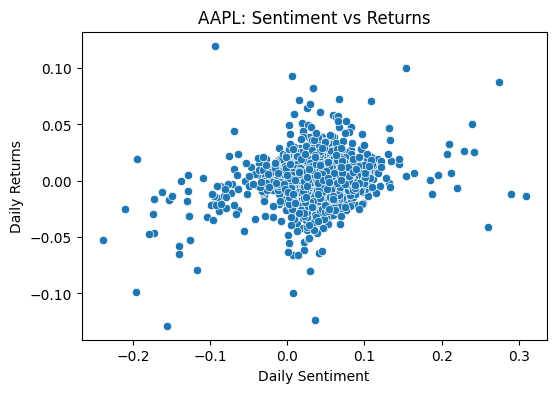

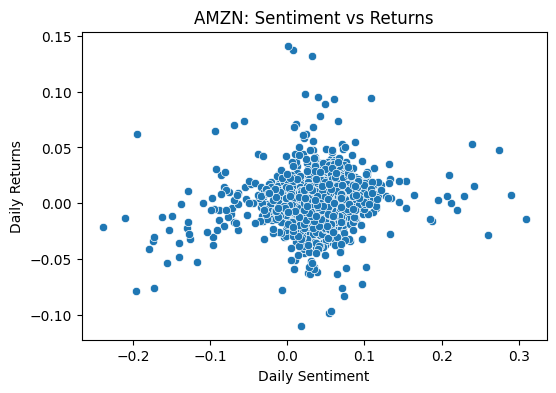

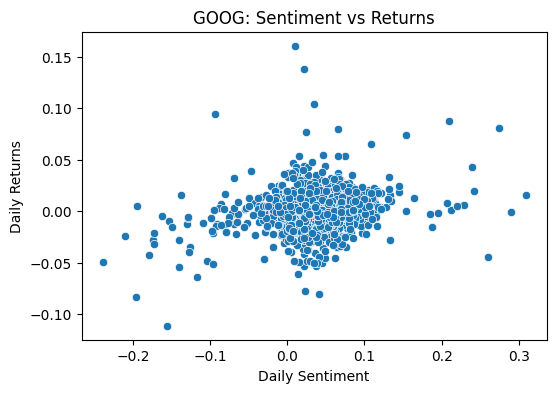

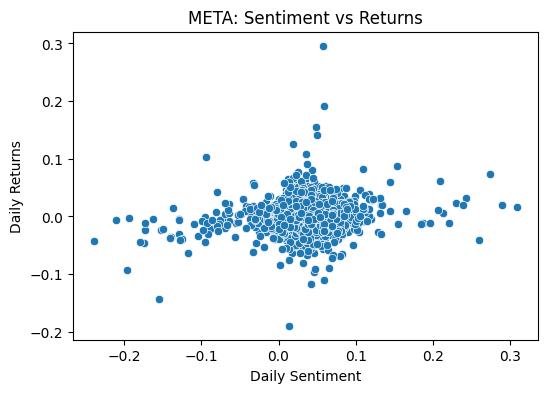

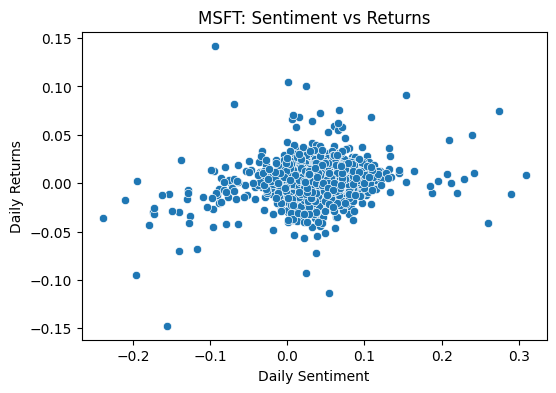

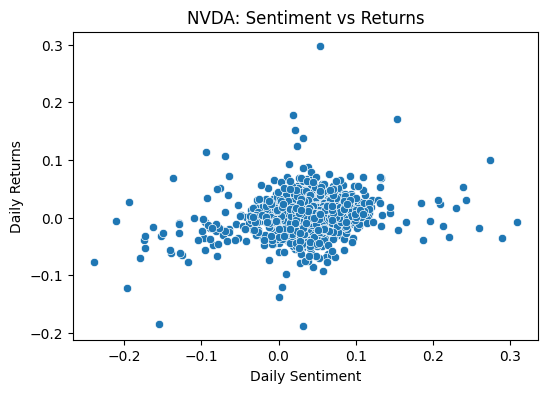

In [101]:
print("Scatter Plot")

for ticker, df in aligned_stock_data.items():
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x="avg_sentiment", y="returns", data=df)
    plt.title(f"{ticker}: Sentiment vs Returns")
    plt.xlabel("Daily Sentiment")
    plt.ylabel("Daily Returns")
    plt.show()

Correlation Matrix


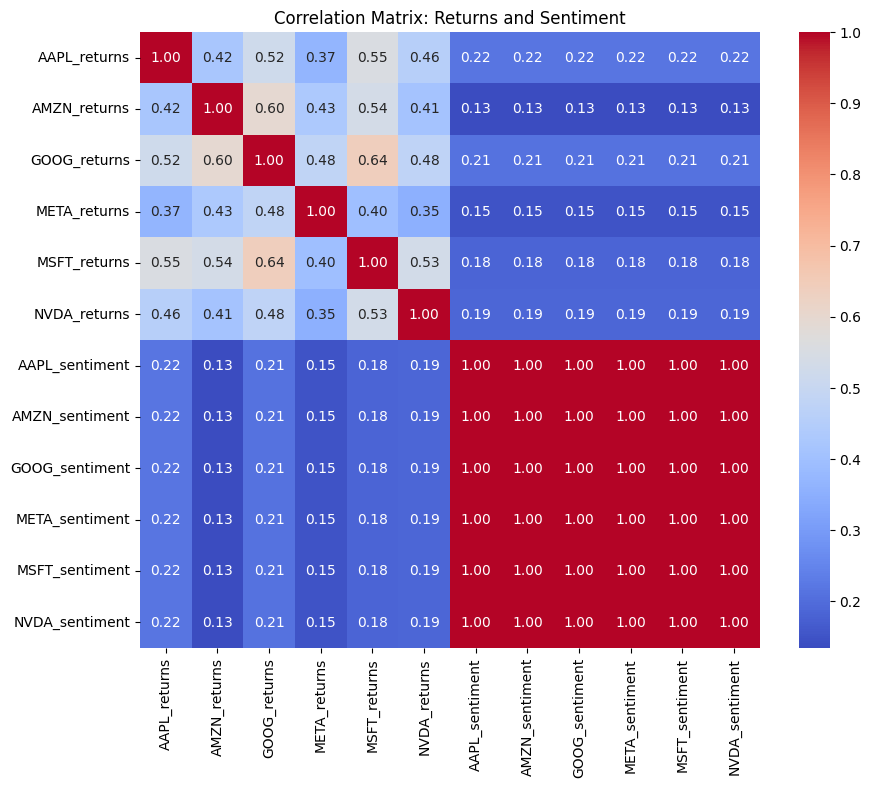

In [103]:
print("Correlation Matrix")

returns_df = pd.DataFrame(
    {ticker: df["returns"] for ticker, df in aligned_stock_data.items()}
)
sentiment_df = pd.DataFrame(
    {ticker: df["avg_sentiment"] for ticker, df in aligned_stock_data.items()}
)

# Compute correlation matrix
combined_corr = pd.concat(
    [returns_df.add_suffix("_returns"), sentiment_df.add_suffix("_sentiment")], axis=1
).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(combined_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix: Returns and Sentiment")
plt.show()